# SVM

Test SVM-Klassifikation

Subsampling:
- Kurve wird nach 800 Punkten (= ms) abgeschnitten
- Auswahl der verwendeten Punkte über Schrittlänge (timestep 80 = 10 Punkte)

In [1]:
import io, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy
from sklearn import model_selection, svm, metrics

import prepare

In [2]:
BASE_DIR = 'renamed'
DATA_OK = ['ok', 'near_ok_sonowechsel']
DATA_FEHLER = ['fehler_oel', 'fehler_leitungsversatz', 'fehler_terminversatz']
DATA_ALL = DATA_OK + DATA_FEHLER

In [3]:
DATA_ALL

['ok',
 'near_ok_sonowechsel',
 'fehler_oel',
 'fehler_leitungsversatz',
 'fehler_terminversatz']

In [4]:
zugversuche, kurven = prepare.read_all(BASE_DIR, DATA_ALL)

ok_: count 200 rows 1407...1650
near_ok_sonowechsel_: count 100 rows 1582...1759
fehler_oel_: count 100 rows 1052...1434
fehler_leitungsversatz_: count 100 rows 1716...2403
fehler_terminversatz_: count 100 rows 1702...2092


Debugausgabe

In [5]:
zugversuche

,nr,festigkeit,key,label,label_text
0,1569,2600.000000,ok_1569,0,ok
1,1570,2750.000000,ok_1570,0,ok
2,1571,2770.000000,ok_1571,0,ok
3,1572,2660.000000,ok_1572,0,ok
4,1573,2810.000000,ok_1573,0,ok
...,...,...,...,...,...
595,2505,1479.522827,fehler_terminversatz_2505,4,fehler_terminversatz
596,2506,2085.117920,fehler_terminversatz_2506,4,fehler_terminversatz
597,2507,2237.231201,fehler_terminversatz_2507,4,fehler_terminversatz
598,2508,2406.469482,fehler_terminversatz_2508,4,fehler_terminversatz


In [6]:
versuche_train, versuche_test = model_selection.train_test_split(zugversuche, test_size=0.2, random_state=42)

Abschneiden auf 800 ms, Subsampling auf 10 Punkte

In [7]:
subsample = prepare.Subsample1(800, 80)
subsample.fit() # Dummy

Subsample1(subsample=80, ts_len=800)

In [8]:
X_train = subsample.transform(versuche_train.key, kurven)
label_train = versuche_train.label.values
festigkeit_train = versuche_train.festigkeit.values
print(X_train.shape, label_train.shape)
print(X_train.max(axis=(0,1)))
#festigkeit_train

(480, 10, 3) (480,)
[3.62556e+03 6.23066e+02 3.34000e+00]


In [9]:
X_test = subsample.transform(versuche_test.key, kurven)
label_test = versuche_test.label.values
festigkeit_test = versuche_test.festigkeit.values
print(X_test.shape)
print(X_test.max(axis=(0,1)))
#festigkeit_train

(120, 10, 3)
[3.47966e+03 6.13300e+02 3.16000e+00]


Skalieren Trainingsdaten

In [10]:
tsMaxScale = prepare.TsMaxScaler()
X_train_scaled = tsMaxScale.fit_transform(X_train)

Skalieren Testdaten

In [11]:
X_test_scaled = tsMaxScale.transform(X_test)

In [12]:
def class_curves(X, ax, y, field):
    color = ['black', 'blue', 'red', 'green', 'cyan']
    ti = np.arange(0, X.shape[1]) # Zeitschritte
    for i in range(X.shape[0]):
        #print(X[i,:,ax])
        plt.plot(ti, X[i,:,ax], c=color[y[i]], linewidth=0.5, alpha=0.5)
    handles = [
        matplotlib.lines.Line2D([0], [0], color='black', label='ok'),
        matplotlib.lines.Line2D([0], [0], color='blue', label='ok_wechsel'),
        matplotlib.lines.Line2D([0], [0], color='red', label='oel'),
        matplotlib.lines.Line2D([0], [0], color='green', label='leitung'),
        matplotlib.lines.Line2D([0], [0], color='cyan', label='termin'),
    ]
    plt.legend(handles=handles)

Anzeige Kurven zur Kontrolle.

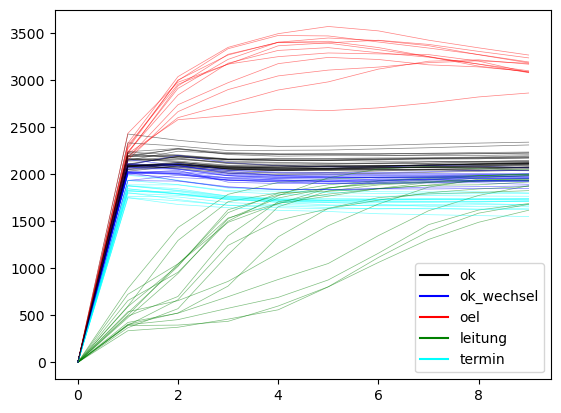

In [13]:
class_curves(X_train[:100,:,:], 0, label_train[:100], 'power')

SVM kann nur 2-D-Daten: Flatten

Alternativ: nur Power verwenden (hier bessere Ergebnisse)

In [14]:
dims = X_train.shape
#X2_train = X_train_scaled.reshape(-1, dims[1]*dims[2])
#X2_test = X_test_scaled.reshape(-1, dims[1]*dims[2])
X2_train = X_train_scaled[:,:,0]
X2_test = X_test_scaled[:,:,0]

Kernel-SVM (Klassifikation) mit Standard-Parametern

In [15]:
estimator = svm.SVC()
_ = estimator.fit(X2_train, label_train)

Accuracy

In [16]:
score_train = estimator.score(X2_train, label_train)
score_test = estimator.score(X2_test, label_test)
score_train, score_test

(0.95, 0.9166666666666666)

Anzeige Confusion Matrix (Testdaten)

In [17]:
def plot_confusion(y_true, y_pred):
    conf = metrics.confusion_matrix(y_true, y_pred)
    sns.heatmap(conf, annot=True)
    plt.xlabel('predict')
    plt.ylabel('truth')

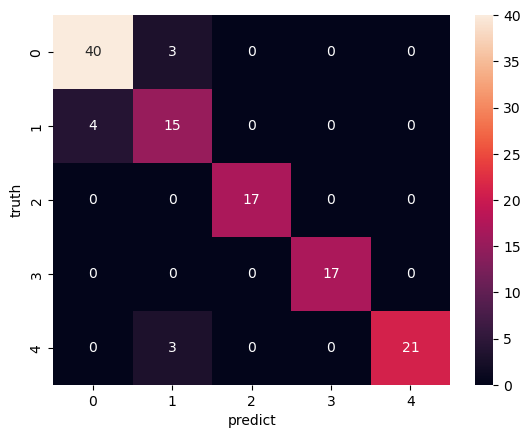

In [18]:
pred_test = estimator.predict(X2_test)
plot_confusion(label_test, pred_test)
plt.savefig('svc_test_confusion.png')

SVM-Regressor (Standardparameter)

In [19]:
regr = svm.SVR()
_= regr.fit(X2_train, festigkeit_train)

Vorhersage Trainingsdaten

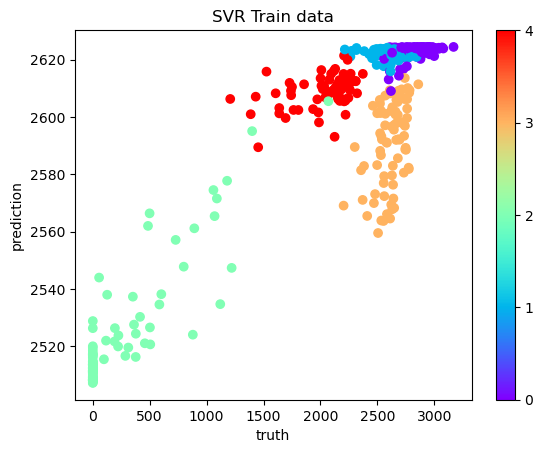

In [20]:
y_pred_train = regr.predict(X2_train)
plt.scatter(festigkeit_train, y_pred_train, c=label_train, cmap='rainbow')
plt.title('SVR Train data')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.colorbar(ticks=np.arange(5))
plt.savefig('svr_train.png')

Vorhersage Testdaten

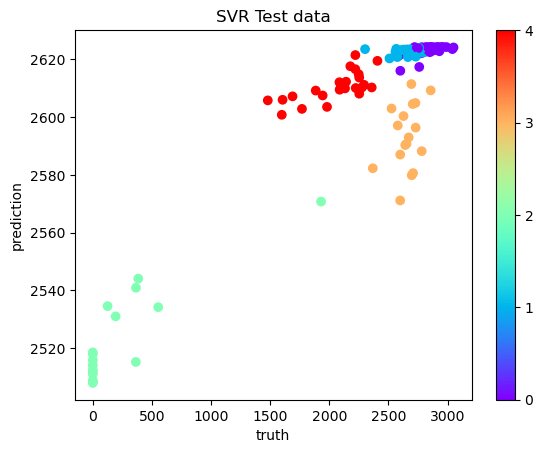

In [21]:
y_pred_test = regr.predict(X2_test)
plt.scatter(festigkeit_test, y_pred_test, c=label_test, cmap='rainbow')
plt.title('SVR Test data')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.colorbar(ticks=np.arange(5))
plt.savefig('svr_test.png')

In [22]:
mse_train = metrics.mean_squared_error(festigkeit_train, y_pred_train)
mse_test = metrics.mean_squared_error(festigkeit_test, y_pred_test)
print(f"MSE: train {mse_train:8.1f}, test: {mse_test:8.1f}")
print(f"RMSE: train {np.sqrt(mse_train):8.1f} test: {np.sqrt(mse_test):8.1f}")
mae_train = metrics.mean_absolute_error(festigkeit_train, y_pred_train)
mae_test = metrics.mean_absolute_error(festigkeit_test, y_pred_test)
print(f"MAE: train {mae_train:8.1f}, test: {mae_test:8.1f}")


MSE: train 1005380.1, test: 869969.4
RMSE: train   1002.7 test:    932.7
MAE: train    584.8, test:    541.3


Debug: Verteilung Festigkeiten

<Axes: ylabel='Frequency'>

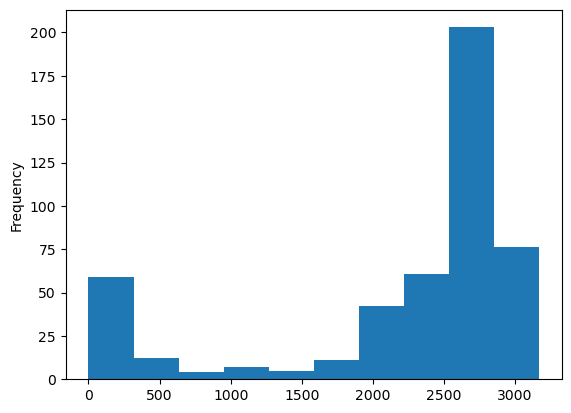

In [23]:
versuche_train.festigkeit.plot(kind='hist')

Hyperparametersuche

https://scikit-learn.org/1.5/modules/grid_search.html

In [24]:
params = {
    #'C': scipy.stats.expon(100),
    #'gamma': scipy.stats.expon(0.01),
    'C': np.logspace(0, 4),
    'gamma': np.logspace(-5, 1),
}
estim2 = model_selection.RandomizedSearchCV(
    svm.SVR(),
    params,
    n_iter=30,
)
estim2.fit(X2_train, festigkeit_train)
print('Best paramaters:', estim2.best_params_)
best_estim = estim2.best_estimator_


Best paramaters: {'gamma': 1.8420699693267164, 'C': 5689.866029018293}


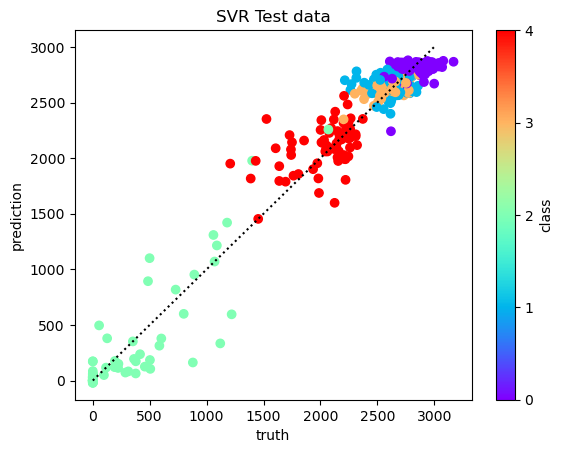

In [25]:
y_pred_train = best_estim.predict(X2_train)
plt.scatter(festigkeit_train, y_pred_train, c=label_train, cmap='rainbow')
plt.plot([0, 3000], [0,3000], "k:")
plt.title('SVR Test data')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.colorbar(ticks=np.arange(5), label='class')
plt.savefig('svr_randsearch_train.png')

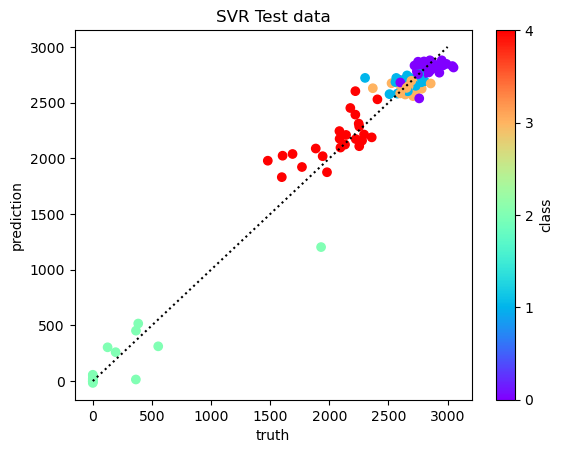

In [26]:
y_pred_test = best_estim.predict(X2_test)
plt.scatter(festigkeit_test, y_pred_test, c=label_test, cmap='rainbow')
plt.plot([0, 3000], [0,3000], "k:")
plt.title('SVR Test data')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.colorbar(ticks=np.arange(5), label='class')
plt.savefig('svr_randsearch_test.png')

In [27]:
y_pred_train = best_estim.predict(X2_train)
y_pred_test = best_estim.predict(X2_test)
mse_train = metrics.mean_squared_error(festigkeit_train, y_pred_train)
mse_test = metrics.mean_squared_error(festigkeit_test, y_pred_test)
print(f"MSE: train {mse_train:8.1f}, test: {mse_test:8.1f}")
print(f"RMSE: train {np.sqrt(mse_train):8.1f} test: {np.sqrt(mse_test):8.1f}")
mae_train = metrics.mean_absolute_error(festigkeit_train, y_pred_train)
mae_test = metrics.mean_absolute_error(festigkeit_test, y_pred_test)
print(f"MAE: train {mae_train:8.1f}, test: {mae_test:8.1f}")
# mapi ist nutzlos durch 0-Werte bei Zugfestigkeit
#mapi_train = metrics.mean_absolute_percentage_error(festigkeit_train, y_pred_train)
#mapi_test = metrics.mean_absolute_percentage_error(festigkeit_test, y_pred_test)
#print(f"MAPI: train {mapi_train:8.1f}, test: {mapi_test:8.1f}")



MSE: train  27416.3, test:  22358.5
RMSE: train    165.6 test:    149.5
MAE: train    110.2, test:     98.8
